In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

/home/dulab/anaconda3/envs/pythonProject1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/dulab/Downloads/transfer_learning/alexnet_test5classes/data'

train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
# test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=32, shuffle=True, num_workers=4)
# test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

class_names = train_datasets.classes

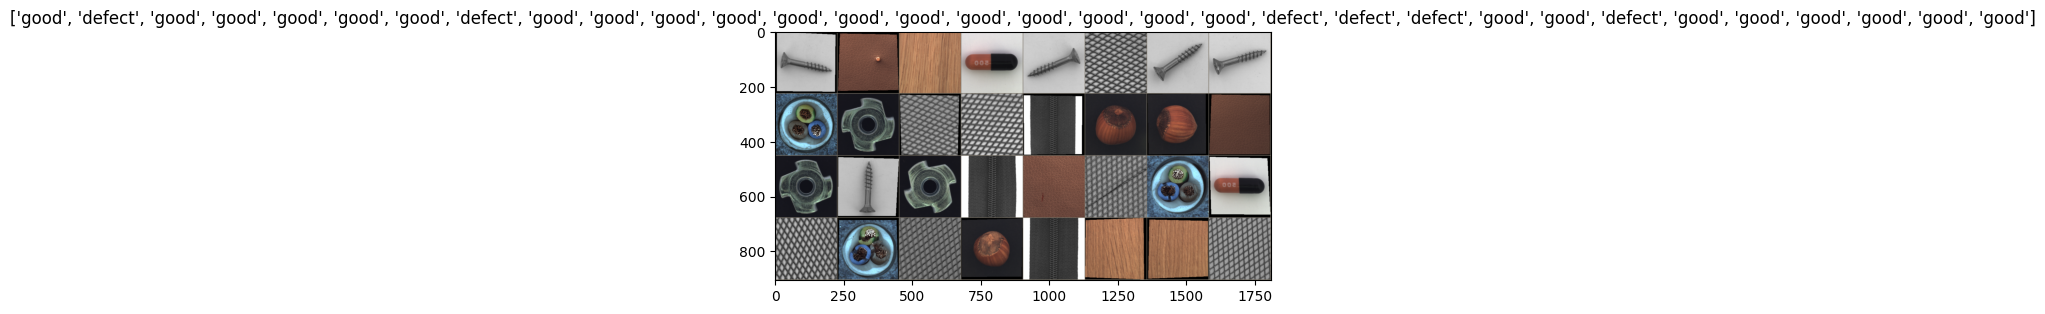

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
train_datasets

Dataset ImageFolder
    Number of datapoints: 3046
    Root location: /home/dulab/Downloads/transfer_learning/alexnet_test5classes/data/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomPerspective(p=0.5)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
val_datasets

Dataset ImageFolder
    Number of datapoints: 524
    Root location: /home/dulab/Downloads/transfer_learning/alexnet_test5classes/data/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
def evaluation(model, dataloader):
    model.eval()
    dataset_size = len(dataloader.dataset)
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return epoch_acc, epoch_loss

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    val_epoch_acc = 0 
    train_dataset_size = len(train_dataloader.dataset)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
   
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0
        i = 0
            
        model.train() 
        # Iterate over data during the training stage.
        for inputs, labels in train_dataloader:
            i = i+1
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize  phase
                loss.backward()
                optimizer.step()

                # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
            
        train_epoch_loss = running_loss / train_dataset_size
        train_loss.append(train_epoch_loss)
        train_epoch_acc = running_corrects.double() / train_dataset_size
        train_acc.append(train_epoch_acc.item())
        print(f'Train loss: {train_epoch_loss:.4f} Training_acc: {train_epoch_acc:.4f}')
        
        val_since = time.time()
        val_epoch_acc, val_epoch_loss = evaluation(model, val_dataloader)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc.item())
        val_time = time.time() - val_since
        print(f'Val complete in {val_time:4f} seconds.')
        print(f'Val loss: {val_epoch_loss:.4f} Val acc: {val_epoch_acc:.4f}')
        
        # deep copy the model
        if  val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(i)

    time_elapsed = time.time() - since
    print(f'Training and validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.4f}s')
    print(f'Best Val Acc: {best_val_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc 

In [10]:
def loss_plot(train_loss, val_loss, index, epoch_num, lr):
    x = np.arange(epoch_num)
    plt.plot(x, train_loss, 'r-+', label='Train loss')
    plt.plot(x, val_loss, 'b-o', label='Val loss')  
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    title = 'Train and val loss with ' + str(index) + ' layer(s) locked and learning rate set to ' + str(lr)
    plt.title(title)
    plt.legend()
    plt.show()
    
def acc_plot(train_acc, val_acc, index, epoch_num, lr):
    x = np.arange(epoch_num)
    plt.plot(x, train_acc, 'r-+', label='Train acc')
    plt.plot(x, val_acc, 'b-o', label='Val acc')  
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    title = 'Train and val acc with ' + str(index) + ' layer(s) locked and learning rate set to ' + str(lr)
    plt.title(title)
    plt.legend()
    plt.show()

In [11]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
epoch_num = 30
criterion = nn.CrossEntropyLoss()
learning_rate = 3e-5

In [12]:
vgg = models.vgg16(pretrained=True)
vgg.classifier[3] = nn.Linear(4096, 1000)
vgg.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg.classifier[3].weight)
nn.init.xavier_uniform_(vgg.classifier[6].weight)
vgg = vgg.to(device)

In [13]:
block1 = [0, 2]
block2 = [5, 7]
block3 = [10, 12, 14]
block4 = [17, 19, 21]
block5 = [24, 26, 28]

In [14]:
# Fine-tine
optimizer = torch.optim.Adam([{'params': vgg.features.parameters()}, 
    {'params': vgg.classifier.parameters(), 'lr': learning_rate * 10}], 
    lr=learning_rate, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
vgg, train_loss, train_acc, val_loss, val_acc = train_model(vgg, criterion, optimizer, exp_lr_scheduler, epoch_num)
train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

Epoch 0/29
----------
Train loss: 0.6934 Training_acc: 0.7741
Val complete in 3.244411 seconds.
Val loss: 0.6458 Val acc: 0.6660
96
Epoch 1/29
----------
Train loss: 0.4085 Training_acc: 0.8313
Val complete in 3.121295 seconds.
Val loss: 0.6676 Val acc: 0.7290
96
Epoch 2/29
----------
Train loss: 0.2795 Training_acc: 0.8907
Val complete in 3.136875 seconds.
Val loss: 0.4609 Val acc: 0.8416
96
Epoch 3/29
----------
Train loss: 0.2315 Training_acc: 0.9110
Val complete in 3.062382 seconds.
Val loss: 0.5273 Val acc: 0.7805
96
Epoch 4/29
----------
Train loss: 0.1642 Training_acc: 0.9366
Val complete in 3.254408 seconds.
Val loss: 0.5711 Val acc: 0.7920
96
Epoch 5/29
----------
Train loss: 0.1411 Training_acc: 0.9455
Val complete in 3.167374 seconds.
Val loss: 0.4103 Val acc: 0.8473
96
Epoch 6/29
----------
Train loss: 0.1068 Training_acc: 0.9603
Val complete in 3.171478 seconds.
Val loss: 0.3840 Val acc: 0.9008
96
Epoch 7/29
----------
Train loss: 0.1076 Training_acc: 0.9619
Val complete i

In [15]:
# freeze the trainable parameters of 1st block
vgg1 = models.vgg16(pretrained=True)
vgg1.classifier[3] = nn.Linear(4096, 1000)
vgg1.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg1.classifier[3].weight)
nn.init.xavier_uniform_(vgg1.classifier[6].weight)
vgg1 = vgg1.to(device)

for i in block1:
    vgg1.features[i].weight.requires_grad = False
    vgg1.features[i].bias.requires_grad = False

In [16]:
optimizer = torch.optim.Adam([{'params': vgg1.features.parameters()}, 
    {'params': vgg1.classifier.parameters(), 'lr': learning_rate * 10}], 
    lr=learning_rate, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
vgg1, train_loss, train_acc, val_loss, val_acc = train_model(vgg1, criterion, optimizer, exp_lr_scheduler, epoch_num)

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

Epoch 0/29
----------
Train loss: 0.7139 Training_acc: 0.7728
Val complete in 3.145255 seconds.
Val loss: 0.8795 Val acc: 0.5706
96
Epoch 1/29
----------
Train loss: 0.4549 Training_acc: 0.8148
Val complete in 3.131206 seconds.
Val loss: 0.6126 Val acc: 0.6832
96
Epoch 2/29
----------
Train loss: 0.3057 Training_acc: 0.8808
Val complete in 3.146299 seconds.
Val loss: 0.6002 Val acc: 0.7615
96
Epoch 3/29
----------
Train loss: 0.2251 Training_acc: 0.9169
Val complete in 3.186285 seconds.
Val loss: 0.4841 Val acc: 0.8340
96
Epoch 4/29
----------
Train loss: 0.2124 Training_acc: 0.9219
Val complete in 3.131848 seconds.
Val loss: 0.4698 Val acc: 0.8321
96
Epoch 5/29
----------
Train loss: 0.1528 Training_acc: 0.9445
Val complete in 3.233940 seconds.
Val loss: 0.5389 Val acc: 0.8225
96
Epoch 6/29
----------
Train loss: 0.1469 Training_acc: 0.9465
Val complete in 3.203576 seconds.
Val loss: 0.3730 Val acc: 0.8626
96
Epoch 7/29
----------
Train loss: 0.1232 Training_acc: 0.9576
Val complete i

In [17]:
# freeze the trainable parameters of first 2 blocks
vgg2 = models.vgg16(pretrained=True)
vgg2.classifier[3] = nn.Linear(4096, 1000)
vgg2.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg2.classifier[3].weight)
nn.init.xavier_uniform_(vgg2.classifier[6].weight)
vgg2 = vgg2.to(device)

for i in block1:
    vgg2.features[i].weight.requires_grad = False
    vgg2.features[i].bias.requires_grad = False

for i in block2:
    vgg2.features[i].weight.requires_grad = False
    vgg2.features[i].bias.requires_grad = False

In [18]:
optimizer = torch.optim.Adam([{'params': vgg2.features.parameters()}, 
    {'params': vgg2.classifier.parameters(), 'lr': learning_rate * 10}], 
    lr=learning_rate, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
vgg2, train_loss, train_acc, val_loss, val_acc = train_model(vgg2, criterion, optimizer, exp_lr_scheduler, epoch_num)

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

Epoch 0/29
----------
Train loss: 0.6906 Training_acc: 0.7685
Val complete in 3.158754 seconds.
Val loss: 0.7346 Val acc: 0.5878
96
Epoch 1/29
----------
Train loss: 0.3844 Training_acc: 0.8454
Val complete in 3.189077 seconds.
Val loss: 0.6766 Val acc: 0.7061
96
Epoch 2/29
----------
Train loss: 0.2873 Training_acc: 0.8858
Val complete in 3.230150 seconds.
Val loss: 0.6203 Val acc: 0.7901
96
Epoch 3/29
----------
Train loss: 0.2079 Training_acc: 0.9219
Val complete in 3.094688 seconds.
Val loss: 0.4255 Val acc: 0.8397
96
Epoch 4/29
----------
Train loss: 0.1627 Training_acc: 0.9416
Val complete in 3.313661 seconds.
Val loss: 0.4803 Val acc: 0.8511
96
Epoch 5/29
----------
Train loss: 0.1424 Training_acc: 0.9540
Val complete in 3.167866 seconds.
Val loss: 0.3902 Val acc: 0.8836
96
Epoch 6/29
----------
Train loss: 0.1197 Training_acc: 0.9547
Val complete in 3.188246 seconds.
Val loss: 0.4002 Val acc: 0.8874
96
Epoch 7/29
----------
Train loss: 0.1053 Training_acc: 0.9652
Val complete i

In [19]:
# freeze the trainable parameters of first 3 blocks
vgg3 = models.vgg16(pretrained=True)
vgg3.classifier[3] = nn.Linear(4096, 1000)
vgg3.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg3.classifier[3].weight)
nn.init.xavier_uniform_(vgg3.classifier[6].weight)
vgg3 = vgg3.to(device)

for i in block1:
    vgg3.features[i].weight.requires_grad = False
    vgg3.features[i].bias.requires_grad = False

for i in block2:
    vgg3.features[i].weight.requires_grad = False
    vgg3.features[i].bias.requires_grad = False
    
for i in block3:
    vgg3.features[i].weight.requires_grad = False
    vgg3.features[i].bias.requires_grad = False

In [20]:
optimizer = torch.optim.Adam([{'params': vgg3.features.parameters()}, 
    {'params': vgg3.classifier.parameters(), 'lr': learning_rate * 10}], 
    lr=learning_rate, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
vgg3, train_loss, train_acc, val_loss, val_acc = train_model(vgg3, criterion, optimizer, exp_lr_scheduler, epoch_num)

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

Epoch 0/29
----------
Train loss: 0.7024 Training_acc: 0.7722
Val complete in 3.239024 seconds.
Val loss: 0.8406 Val acc: 0.6279
96
Epoch 1/29
----------
Train loss: 0.3688 Training_acc: 0.8454
Val complete in 3.069360 seconds.
Val loss: 0.4652 Val acc: 0.7710
96
Epoch 2/29
----------
Train loss: 0.2666 Training_acc: 0.8920
Val complete in 3.240613 seconds.
Val loss: 0.5159 Val acc: 0.7882
96
Epoch 3/29
----------
Train loss: 0.1897 Training_acc: 0.9265
Val complete in 3.342622 seconds.
Val loss: 0.4938 Val acc: 0.8435
96
Epoch 4/29
----------
Train loss: 0.1645 Training_acc: 0.9458
Val complete in 3.154344 seconds.
Val loss: 0.3738 Val acc: 0.8531
96
Epoch 5/29
----------
Train loss: 0.1298 Training_acc: 0.9521
Val complete in 3.078937 seconds.
Val loss: 0.4141 Val acc: 0.8626
96
Epoch 6/29
----------
Train loss: 0.0930 Training_acc: 0.9685
Val complete in 3.110086 seconds.
Val loss: 0.7272 Val acc: 0.8626
96
Epoch 7/29
----------
Train loss: 0.0893 Training_acc: 0.9714
Val complete i

In [21]:
# freeze the trainable parameters of first 4 blocks
vgg4 = models.vgg16(pretrained=True)
vgg4.classifier[3] = nn.Linear(4096, 1000)
vgg4.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg4.classifier[3].weight)
nn.init.xavier_uniform_(vgg4.classifier[6].weight)
vgg4 = vgg4.to(device)

for i in block1:
    vgg4.features[i].weight.requires_grad = False
    vgg4.features[i].bias.requires_grad = False

for i in block2:
    vgg4.features[i].weight.requires_grad = False
    vgg4.features[i].bias.requires_grad = False
    
for i in block3:
    vgg4.features[i].weight.requires_grad = False
    vgg4.features[i].bias.requires_grad = False
    
for i in block4:
    vgg4.features[i].weight.requires_grad = False
    vgg4.features[i].bias.requires_grad = False

In [22]:
optimizer = torch.optim.Adam([{'params': vgg4.features.parameters()}, 
    {'params': vgg4.classifier.parameters(), 'lr': learning_rate * 10}], 
    lr=learning_rate, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
vgg4, train_loss, train_acc, val_loss, val_acc = train_model(vgg4, criterion, optimizer, exp_lr_scheduler, epoch_num)

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

Epoch 0/29
----------
Train loss: 0.7645 Training_acc: 0.7495
Val complete in 3.206252 seconds.
Val loss: 0.6563 Val acc: 0.6202
96
Epoch 1/29
----------
Train loss: 0.3937 Training_acc: 0.8414
Val complete in 3.138603 seconds.
Val loss: 0.5690 Val acc: 0.7538
96
Epoch 2/29
----------
Train loss: 0.3010 Training_acc: 0.8785
Val complete in 3.196290 seconds.
Val loss: 0.5728 Val acc: 0.7729
96
Epoch 3/29
----------
Train loss: 0.2257 Training_acc: 0.9110
Val complete in 3.186112 seconds.
Val loss: 0.7867 Val acc: 0.7290
96
Epoch 4/29
----------
Train loss: 0.1921 Training_acc: 0.9228
Val complete in 3.147220 seconds.
Val loss: 0.5988 Val acc: 0.8206
96
Epoch 5/29
----------
Train loss: 0.1598 Training_acc: 0.9386
Val complete in 3.210581 seconds.
Val loss: 0.5629 Val acc: 0.8034
96
Epoch 6/29
----------
Train loss: 0.1498 Training_acc: 0.9416
Val complete in 3.211179 seconds.
Val loss: 0.4968 Val acc: 0.8473
96
Epoch 7/29
----------
Train loss: 0.1255 Training_acc: 0.9534
Val complete i

In [23]:
# freeze the trainable parameters of first 4 blocks
vgg5 = models.vgg16(pretrained=True)
vgg5.classifier[3] = nn.Linear(4096, 1000)
vgg5.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg5.classifier[3].weight)
nn.init.xavier_uniform_(vgg5.classifier[6].weight)
vgg5 = vgg5.to(device)

for i in block1:
    vgg5.features[i].weight.requires_grad = False
    vgg5.features[i].bias.requires_grad = False

for i in block2:
    vgg5.features[i].weight.requires_grad = False
    vgg5.features[i].bias.requires_grad = False
    
for i in block3:
    vgg5.features[i].weight.requires_grad = False
    vgg5.features[i].bias.requires_grad = False
    
for i in block4:
    vgg5.features[i].weight.requires_grad = False
    vgg5.features[i].bias.requires_grad = False
    
for i in block5:
    vgg5.features[i].weight.requires_grad = False
    vgg5.features[i].bias.requires_grad = False

In [24]:
optimizer = torch.optim.Adam([{'params': vgg5.features.parameters()}, 
    {'params': vgg5.classifier.parameters(), 'lr': learning_rate * 10}], 
    lr=learning_rate, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
vgg5, train_loss, train_acc, val_loss, val_acc = train_model(vgg5, criterion, optimizer, exp_lr_scheduler, epoch_num)

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

Epoch 0/29
----------
Train loss: 1.7542 Training_acc: 0.7104
Val complete in 3.116171 seconds.
Val loss: 1.3737 Val acc: 0.6183
96
Epoch 1/29
----------
Train loss: 0.9073 Training_acc: 0.7528
Val complete in 3.348012 seconds.
Val loss: 0.8917 Val acc: 0.6546
96
Epoch 2/29
----------
Train loss: 0.6004 Training_acc: 0.7886
Val complete in 3.040934 seconds.
Val loss: 0.7344 Val acc: 0.6737
96
Epoch 3/29
----------
Train loss: 0.4926 Training_acc: 0.7945
Val complete in 3.252766 seconds.
Val loss: 0.5810 Val acc: 0.6775
96
Epoch 4/29
----------
Train loss: 0.4490 Training_acc: 0.8175
Val complete in 3.081967 seconds.
Val loss: 0.5643 Val acc: 0.7214
96
Epoch 5/29
----------
Train loss: 0.4211 Training_acc: 0.8201
Val complete in 3.169196 seconds.
Val loss: 0.6708 Val acc: 0.7080
96
Epoch 6/29
----------
Train loss: 0.3877 Training_acc: 0.8349
Val complete in 3.114089 seconds.
Val loss: 0.7065 Val acc: 0.6756
96
Epoch 7/29
----------
Train loss: 0.3842 Training_acc: 0.8464
Val complete i

In [25]:
save_dir = '/home/dulab/Downloads/transfer_learning/vgg16/model/vgg_aug_sche'

In [26]:
torch.save(vgg, os.path.join(save_dir, 'vgg.pth'))
torch.save(vgg1, os.path.join(save_dir, 'vgg1.pth'))
torch.save(vgg2, os.path.join(save_dir, 'vgg2.pth'))
torch.save(vgg3, os.path.join(save_dir, 'vgg3.pth'))
torch.save(vgg4, os.path.join(save_dir, 'vgg4.pth'))
torch.save(vgg5, os.path.join(save_dir, 'vgg5.pth'))

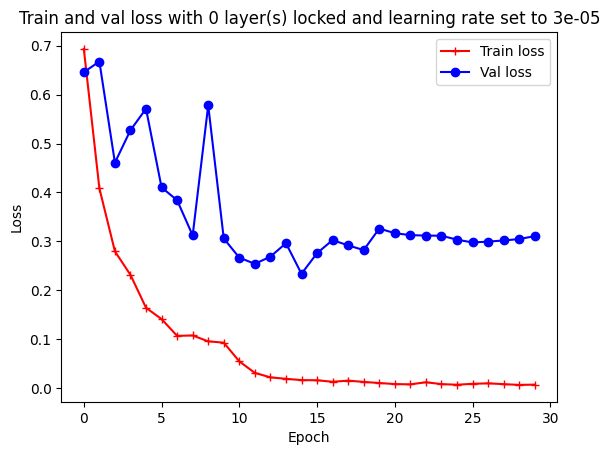

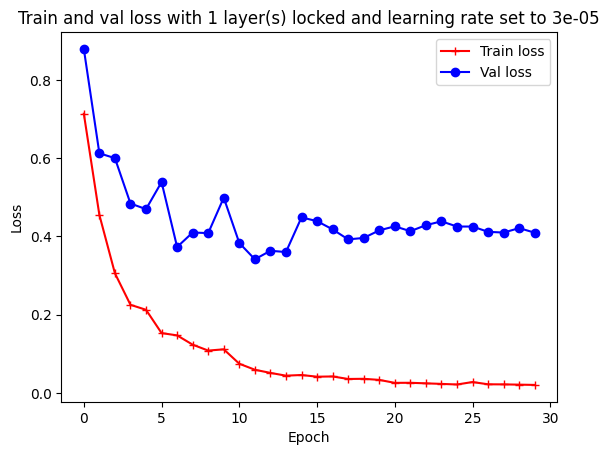

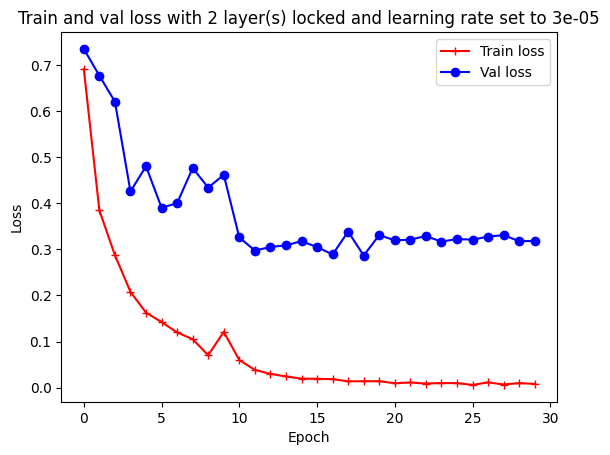

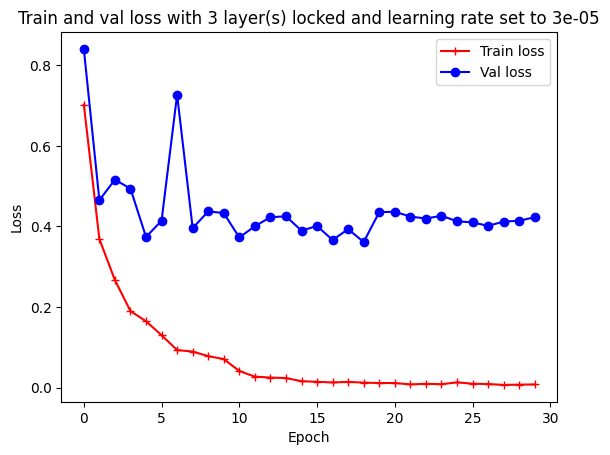

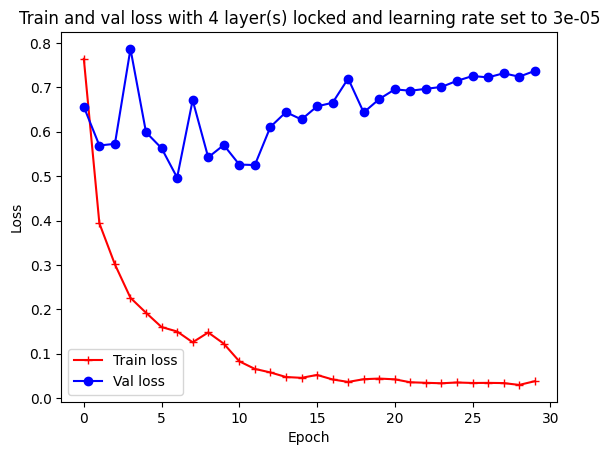

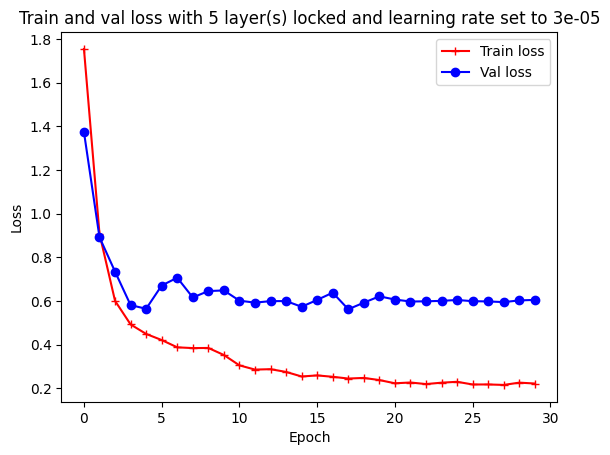

In [27]:
for i in range(6):
    loss_plot(train_loss_list[i], val_loss_list[i], i, epoch_num, learning_rate)

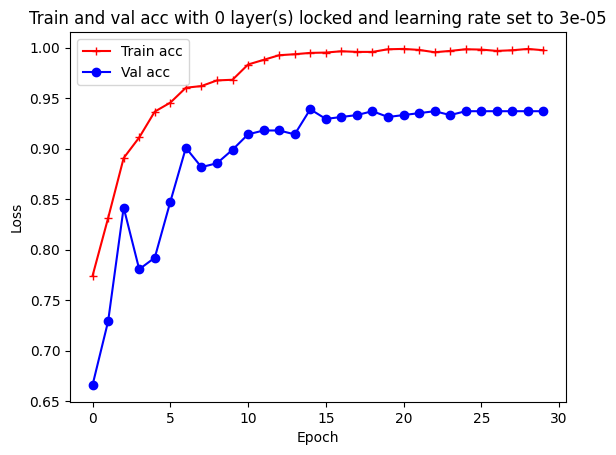

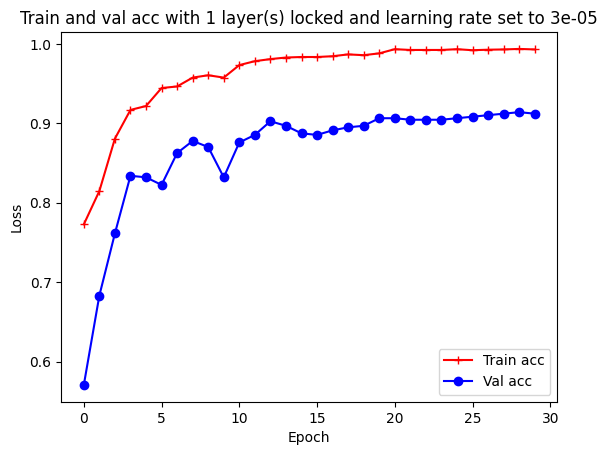

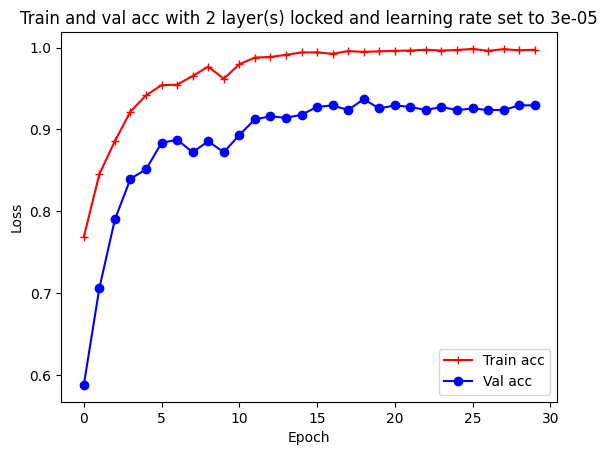

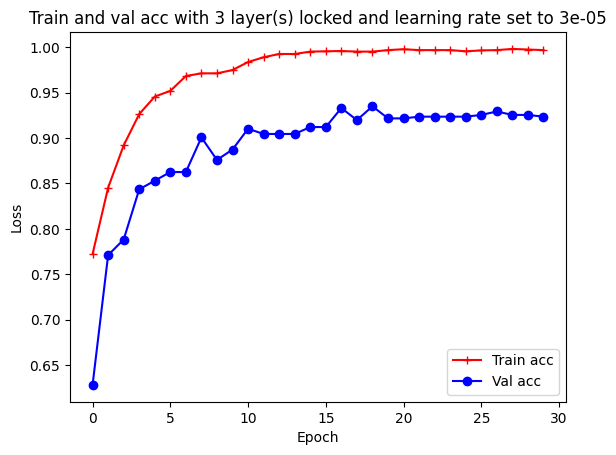

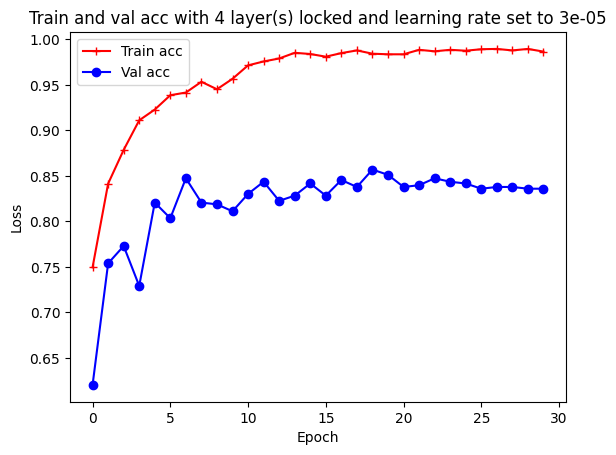

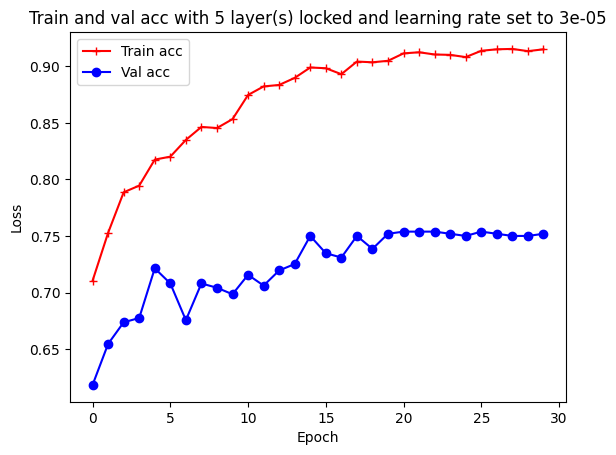

In [28]:
for i in range(6):
    acc_plot(train_acc_list[i], val_acc_list[i], i, epoch_num, learning_rate)